<a href="https://colab.research.google.com/github/Pealie/GettingDataCoursera/blob/master/Building_a_weather_station_with_TensorFlow_Lite_for_Microcontrollers_Aviemore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Retrieving weather data for lochaber


Currently retrieving data for lochaber: from 2011-01-01 to 2011-01-31
Time elapsed (hh:mm:ss.ms) 0:00:05.894463
Currently retrieving data for lochaber: from 2011-02-01 to 2011-02-28
Time elapsed (hh:mm:ss.ms) 0:00:09.290756
Currently retrieving data for lochaber: from 2011-03-01 to 2011-03-31
Time elapsed (hh:mm:ss.ms) 0:00:11.801159
Currently retrieving data for lochaber: from 2011-04-01 to 2011-04-30
Time elapsed (hh:mm:ss.ms) 0:00:14.937922
Currently retrieving data for lochaber: from 2011-05-01 to 2011-05-31
Time elapsed (hh:mm:ss.ms) 0:00:18.147760
Currently retrieving data for lochaber: from 2011-06-01 to 2011-06-30
Time elapsed (hh:mm:ss.ms) 0:00:20.694351
Currently retrieving data for lochaber: from 2011-07-01 to 2011-07-31
Time elapsed (hh:mm:ss.ms) 0:00:23.468726
Currently retrieving data for lochaber: from 2011-08-01 to 2011-08-31
Time e

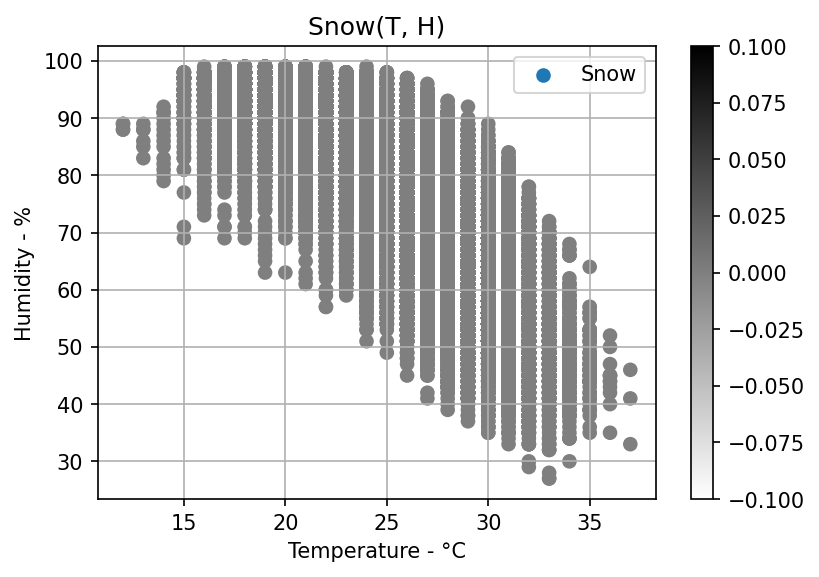

ZeroDivisionError: ignored

In [ ]:
import csv
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sklearn.metrics
import tensorflow as tf

from numpy import mean
from numpy import std
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import activations
from tensorflow.keras import layers

BATCH_SIZE = 64
MELTING_TEMPERATURE = 2
MIN_SNOW_CM = 0.5 # Above this value, we consider it as snow
NUM_EPOCHS = 20
OUTPUT_DATASET_FILE = "snow_dataset.csv"
TFL_MODEL_FILE = "snow_forecast_model.tflite"
TFL_MODEL_HEADER_FILE = "snow_forecast_model.h"
TF_MODEL = "snow_forecast"

!pip install wwo-hist

from wwo_hist import retrieve_hist_data # WorldWeatherOnline

frequency=1
api_key = '77e4f7fb6d4a4376916215131231001'
location_list = ['Aviemore']

# retrieve_hist_data returns a list of dataframe(s)
df_weather = retrieve_hist_data(api_key,
                                location_list,
                                '01-JAN-2011',
                                '31-DEC-2022',
                                frequency,
                                location_label = False,
                                export_csv = False,
                                store_df = True)

# Extract temperature, humidity and precipitation
t_list = df_weather[0].tempC.astype(float).to_list()
h_list = df_weather[0].humidity.astype(float).to_list()
s_list = df_weather[0].totalSnow_cm.astype(float).to_list()
     
def binarize(snow, threshold):
  if snow > threshold:
    return 1
  else:
    return 0

s_bin_list = [binarize(snow, MIN_SNOW_CM) for snow in s_list]

cm = plt.cm.get_cmap('gray_r')
plt.figure(dpi=150)
sc = plt.scatter(t_list, h_list, c=s_bin_list, cmap=cm, label="Snow")
plt.colorbar(sc)
plt.legend()
plt.grid(True)
plt.title("Snow(T, H)")
plt.xlabel("Temperature - °C")
plt.ylabel("Humidity - %")
plt.show()

def gen_label(snow, temperature):
  if snow > MIN_SNOW_CM and temperature < MELTING_TEMPERATURE:
    return "Yes"
  else:
    return "No"

snow_labels = [gen_label(snow, temp) for snow, temp in zip(s_list, t_list)]
     
csv_header = ["Temp0", "Temp1", "Temp2", "Humi0", "Humi1", "Humi2", "Snow"]

df_dataset = pd.DataFrame(list(zip(t_list[:-2], t_list[1:-1], t_list[2:], h_list[:-2], h_list[1:-1], h_list[2:], snow_labels[2:])), columns = csv_header)
     
df0 = df_dataset[df_dataset['Snow'] == "No"]
df1 = df_dataset[df_dataset['Snow'] == "Yes"]

num_nosnow_samples_old = round((len(df0.index) / (len(df_dataset.index))) * 100, 2)
num_snow_samples_old   = round((len(df1.index) / (len(df_dataset.index))) * 100, 2)

# Random subsampling of the majority class to guarantee 50% split
if len(df1.index) < len(df0.index):
  df0_sub = df0.sample(len(df1.index))
  df_dataset = pd.concat([df0_sub, df1])
else:
  df1_sub = df1.sample(len(df0.index))
  df_dataset = pd.concat([df1_sub, df0])

df0 = df_dataset[df_dataset['Snow'] == "No"]
df1 = df_dataset[df_dataset['Snow'] == "Yes"]

num_nosnow_samples_new = round((len(df0.index) / (len(df_dataset.index))) * 100, 2)
num_snow_samples_new = round((len(df1.index) / (len(df_dataset.index))) * 100, 2)

# Show number of samples
df_samples_results = pd.DataFrame.from_records(
                [["% No Snow", num_nosnow_samples_old, num_nosnow_samples_new],
                ["% Snow", num_snow_samples_old, num_snow_samples_new]],
            columns = ["Class", "Before - %", "After - %"], index="Class").round(2)

display(df_samples_results)   

# Get all values
t_list = df_dataset['Temp0'].tolist()
h_list = df_dataset['Humi0'].tolist()
t_list = t_list + df_dataset['Temp2'].tail(2).tolist()
h_list = h_list + df_dataset['Humi2'].tail(2).tolist()

# Calculate mean and standard deviation
t_avg = mean(t_list)
h_avg = mean(h_list)
t_std = std(t_list)
h_std = std(h_list)
print("COPY ME!")
print("Temperature - [MEAN, STD]  ", round(t_avg, 5), round(t_std, 5))
print("Humidity - [MEAN, STD]     ", round(h_avg, 5), round(h_std, 5))

# Scaling with Z-score function
def scaling(val, avg, std):
  return (val - avg) / (std)

df_dataset['Temp0'] = df_dataset['Temp0'].apply(lambda x: scaling(x, t_avg, t_std))
df_dataset['Temp1'] = df_dataset['Temp1'].apply(lambda x: scaling(x, t_avg, t_std))
df_dataset['Temp2'] = df_dataset['Temp2'].apply(lambda x: scaling(x, t_avg, t_std))
df_dataset['Humi0'] = df_dataset['Humi0'].apply(lambda x: scaling(x, h_avg, h_std))
df_dataset['Humi1'] = df_dataset['Humi1'].apply(lambda x: scaling(x, h_avg, h_std))
df_dataset['Humi2'] = df_dataset['Humi2'].apply(lambda x: scaling(x, h_avg, h_std))

t_norm_list = df_dataset['Temp0'].tolist()
h_norm_list = df_dataset['Humi0'].tolist()
t_norm_list = t_norm_list + df_dataset['Temp2'].tail(2).tolist()
h_norm_list = h_norm_list + df_dataset['Humi2'].tail(2).tolist()

fig, ax=plt.subplots(1,2)
plt.subplots_adjust(wspace = 0.4)
sns.distplot(t_list, ax=ax[0])
ax[0].set_title("Un-normalized temperature")
sns.distplot(h_list, ax=ax[1])
ax[1].set_title("Un-normalized humidity")

fig, ax=plt.subplots(1,2)
plt.subplots_adjust(wspace = 0.5)
sns.distplot(t_norm_list, ax=ax[0])
ax[0].set_title("Normalized temperature")
sns.distplot(h_norm_list, ax=ax[1])
ax[1].set_title("Normalized humidity")


df_dataset.to_csv(OUTPUT_DATASET_FILE, index=False)

f_names = df_dataset.columns.values[0:6]
l_name  = df_dataset.columns.values[6:7]
x = df_dataset[f_names]
y = df_dataset[l_name]

labelencoder = LabelEncoder()
labelencoder.fit(y.Snow)
y_encoded = labelencoder.transform(y.Snow)

# Split 1 (85% vs 15%)
x_train, x_validate_test, y_train, y_validate_test = train_test_split(x, y_encoded, test_size=0.15, random_state = 1)
# Split 2 (50% vs 50%)
x_test, x_validate, y_test, y_validate = train_test_split(x_validate_test, y_validate_test, test_size=0.50, random_state = 3)
     
model = tf.keras.Sequential()
model.add(layers.Dense(12, activation='relu', input_shape=(len(f_names),)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_validate, y_validate))
     
loss_train = history.history['loss']
loss_val   = history.history['val_loss']
acc_train  = history.history['accuracy']
acc_val    = history.history['val_accuracy']
epochs     = range(1, NUM_EPOCHS + 1)

def plot_train_val_history(x, y_train, y_val, type_txt):
  plt.figure(figsize = (10,7))
  plt.plot(x, y_train, 'g', label='Training'+type_txt)
  plt.plot(x, y_val, 'b', label='Validation'+type_txt)
  plt.title('Training and Validation'+type_txt)
  plt.xlabel('Epochs')
  plt.ylabel(type_txt)
  plt.legend()
  plt.show()

plot_train_val_history(epochs, loss_train, loss_val, "Loss")
plot_train_val_history(epochs, acc_train, acc_val, "Accuracy")
     
model.save(TF_MODEL)

y_test_pred = model.predict(x_test)

y_test_pred = (y_test_pred > 0.5).astype("int32")

cm = sklearn.metrics.confusion_matrix(y_test, y_test_pred)

index_names  = ["Actual No Snow", "Actual Snow"]
column_names = ["Predicted No Snow", "Predicted Snow"]

df_cm = pd.DataFrame(cm, index = index_names, columns = column_names)

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="Blues")
plt.figure(figsize = (10,7))

TN = cm[0][0]
TP = cm[1][1]
FN = cm[1][0]
FP = cm[0][1]

accuracy = (TP + TN) / (TP + TN + FN + FP)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f_score = (2 * recall * precision) / (recall + precision)

print("Accuracy:  ", round(accuracy, 3))
print("Recall:    ", round(recall, 3))
print("Precision: ", round(precision, 3))
print("F-score:   ", round(f_score, 3))

def representative_data_gen():
  for i_value in tf.data.Dataset.from_tensor_slices(x_test).batch(1).take(100):
    i_value_f32 = tf.dtypes.cast(i_value, tf.float32)
    yield [i_value_f32]

converter = tf.lite.TFLiteConverter.from_saved_model(TF_MODEL)

converter.representative_dataset = tf.lite.RepresentativeDataset(representative_data_gen)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model_quant = converter.convert()
open(TFL_MODEL_FILE, "wb").write(tflite_model_quant)

!apt-get update && apt-get -qq install xxd
!xxd -i snow_forecast_model.tflite > model.h
!cat model.h




# New section

# New section